This notebook walks through how to take a coordinate and return the elevation at that coordinate based on our DSM. It assumes everything will work well such as having DSM at that location and I've removed error handling for simpler viewing - but in cases where failure occurs, first confirm that we actually have DSM available and then contact support@vexcelgroup.com for more help.

First, some functions for doing conversions between the tile numbers and coordinates. This [site](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python) has implementations in other languages.

In [1]:
from vdp_python_tools.tile_math import deg2num, num2deg, degrees_per_pixel, coord_to_pixel

Enter whatever coordiantes you'd like, and change the zoom level if you desire.

In [2]:
zoom = 20
coord = -70.7461930000,42.2192840000

In [3]:
x, y = deg2num(*coord, zoom)

Login and create a query

In [4]:
import requests, json

api = "GetDSMTile"

with open("credentials.json") as fp:
    credentials = json.load(fp) # {'password': 'hopefullyabetterpasswordthanthis', 'username': 'email@address.com'}
    
r = requests.post("https://api.gic.org/auth/Login/", data=credentials)
token = r.json()['token']

url_dsm = f"https://api.vexcelgroup.com/images/{api}/{zoom}/{x}/{y}?token={token}"
url_dsm.replace(token, "{token}") # for seeing the query

'https://api.vexcelgroup.com/images/GetDSMTile/20/318224/388388?token={token}'

In [5]:
from PIL import Image
import io

response = requests.get(url_dsm)
image_dsm = Image.open(io.BytesIO(response.content))

Pillow doesn't read single band elevation tifs very well, but we don't need that anyway, we want a numpy array

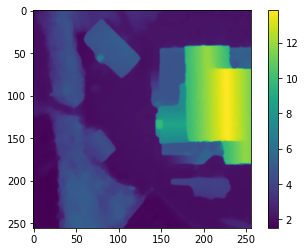

In [6]:
import numpy as np
array_elevation = np.array(image_dsm)
array_elevation

import matplotlib.pyplot as plt

plt.imshow(array_elevation)
cbar = plt.colorbar()


Just to compare, look at the ortho tile

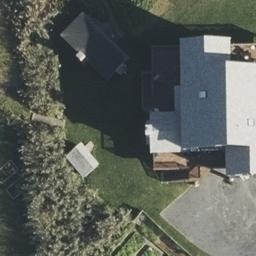

In [7]:
api = "GetOrthoImageTile/bluesky-ultra"
url_rgb = f"https://api.vexcelgroup.com/images/{api}/{zoom}/{x}/{y}?token={token}"

response = requests.get(url_rgb)
image_rgb = Image.open(io.BytesIO(response.content))

image_rgb

Next we compute the bounding box of the tile we grabbed, and then the degrees per pixel in each direction so that we can specify the element in the array representation of the DSM tile.

In [8]:
sw = num2deg(x, y+1, zoom)
ne = num2deg(x + 1, y, zoom)
bounds = [*sw, *ne]

pixels_wide, pixels_high = array_elevation.shape

deg_per_pixel_wide, deg_per_pixel_high = degrees_per_pixel(bounds, pixels_wide, pixels_high)
x_pixel, y_pixel = coord_to_pixel(*coord, bounds, deg_per_pixel_wide, deg_per_pixel_high, pixels_wide, pixels_high)

Now that we know the pixel of the tile corresponding to our `coord` values, we can know the elevation at that point

In [9]:
array_elevation[y_pixel, x_pixel]

11.457101

To validate this, you can write the tile to a tiff and the coordinate to a GeoJSON and drop both into QGIS. Use the inspection tool to validate that the point corresponds to the elevation we just determined (it's off by 0.01m for some reason...)

In [10]:
import shutil

def write_tile_from_api(x, y, zoom, output_filepath, token, api="GetOrthoImageTile/bluesky-ultra", api_parameters = ""):
    url = f"https://api.vexcelgroup.com/images/{api}/{zoom}/{x}/{y}?token={token}" + api_parameters
    response = requests.get(url, stream = True)
    with open(output_filepath, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)

In [11]:
write_tile_from_api(x, y, zoom, "./data/tmp/dsm_tile.tiff", token, api="GetDSMTile")

In [12]:
import json

with open("./data/tmp/point.geojson", "w") as fp:
    json.dump({
        "type": "FeatureCollection",
        "features": [
            {"geometry": {"type": "Point", "coordinates": coord}}
        ]
    }, fp)